# 1: Morphological analysis vis-a-vis MNIST and K-MNIST:

# Based off of this awesome project: https://github.com/dccastro/Morpho-MNIST


In [1]:
# Imports
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import numpy as np
from PIL import Image
from tqdm import tqdm_notebook
import operator
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import os
project_dir=('/gdrive/My Drive/Colab Notebooks/Kannada_MNIST')
os.chdir(project_dir)

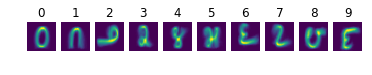

In [3]:
X_KaMnist_test=np.load('./data/output_tensors/X_test_KaMNIST_wc.npy')
y_KaMnist_test=np.load('./data/output_tensors/y_test_KaMNIST_wc.npy')

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(np.mean(X_KaMnist_test[y_KaMnist_test==i,:,:,0], axis=0))
    plt.axis('off')
    plt.title(i)

# Import the functions from Morpho-MNIST.

In [4]:
# ! git clone https://github.com/dccastro/Morpho-MNIST.git
os.chdir('./Morpho-MNIST')
print(os.listdir())
from morphomnist.measure import measure_batch, measure_image
# Source: https://github.com/dccastro/Morpho-MNIST/blob/bb01283636a79b8b4752ea241c2d263f45c84409/experiments/diversity/dist_plots.py
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker


def plot_distribution(data, cols, lims, multiples=(), formats=()):
    lims = [(l - .05 * (h - l), h + .05 * (h - l)) for l, h in lims]
    g = sns.PairGrid(data, vars=cols, diag_sharey=False, size=1.2)
    g.map_diag(plt.hist, bins=20, alpha=.4, density=True)
    g.map_diag(sns.kdeplot, legend=False)
    g.map_lower(sns.kdeplot, cmap='Blues_d', linewidths=1.)
    for i in range(g.axes.shape[0]):
        for j in range(i + 1, g.axes.shape[1]):
            g.axes[i, j].hexbin(data[cols[j]], data[cols[i]],
                                gridsize=30, bins='log', mincnt=1,
                                cmap='Blues', lw=.1, edgecolors='face',
                                extent=[*lims[j], *lims[i]], rasterized=True)

    for i, col in enumerate(cols):
        g.axes[ i, 0].set_ylim(lims[i])
        g.axes[-1, i].set_xlim(lims[i])
        if col in multiples:
            g.axes[ i, 0].yaxis.set_major_locator(ticker.MultipleLocator(multiples[col]))
            g.axes[-1, i].xaxis.set_major_locator(ticker.MultipleLocator(multiples[col]))
        if col in formats:
            g.axes[ i, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter(formats[col]))
            g.axes[-1, i].xaxis.set_major_formatter(ticker.FormatStrFormatter(formats[col]))
            
##############
cols = ['length', 'thickness', 'slant', 'width', 'height']
lims = [(10, 70), (0, 7), (-45, 45), (0, 22), (8, 22)]
multiples = {'length': 20, 'thickness': 2, 'slant': 30, 'width': 10, 'height': 5, 'aspect': .5}
formats = {'slant': "%d\u00b0", 'aspect': "%g"}

['.git', '.gitignore', 'README.md', 'analysis', 'experiments', 'fig1.png', 'models', 'morphomnist', 'scripts']


In [5]:
import pandas as pd
metrics_mnist=pd.read_csv('../data/morpho_mnist/t10k-morpho.csv')
metrics_mnist['slant'] = np.rad2deg(metrics_mnist['slant'])
#################################################################
metrics_ka_mnist=measure_batch(np.squeeze(X_KaMnist_test))
metrics_ka_mnist['slant'] = np.rad2deg(metrics_ka_mnist['slant'])
metrics_ka_mnist.to_csv('../data/morpho_mnist/metrics_ka_mnist_test.csv')

100%|##########| 10000/10000 [20:19<00:00,  8.06img/s]


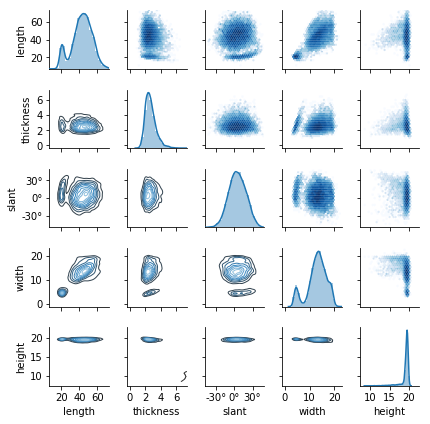

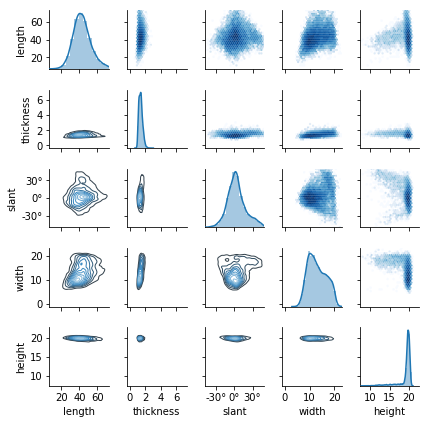

In [6]:
plot_distribution(metrics_mnist, cols, lims, multiples, formats)
plot_distribution(metrics_ka_mnist, cols, lims, multiples, formats)

# UMAP-  Dimensionality reduction visualization:

In [0]:
!pip install umap-learn
!pip install 'numba==0.39.0'
import umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

mnist = fetch_openml('mnist_784', version=1)

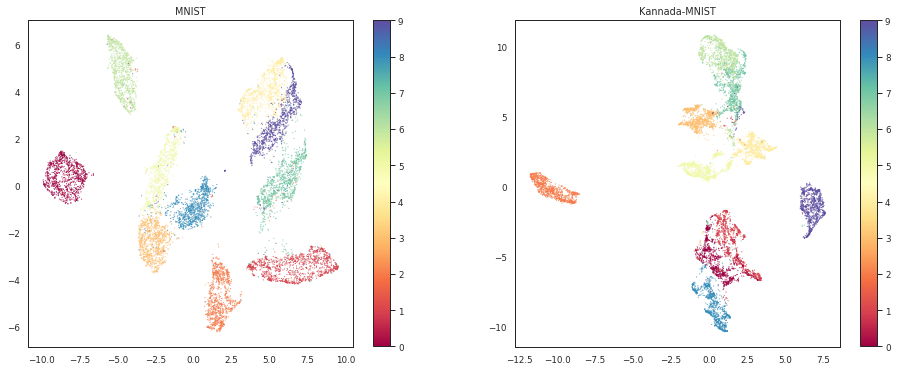

In [34]:
# # # https://github.com/lmcinnes/umap/blob/master/examples/plot_mnist_example.py
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(mnist.data[int(6e4):int(7e4)])



##################################
reducer = umap.UMAP(random_state=42)
X_KaMnist_test_vec=np.squeeze(X_KaMnist_test).reshape(10000,784)
embedding_Ka = reducer.fit_transform(X_KaMnist_test_vec)
##################

plt.figure(figsize=(16, 6))
color = mnist.target[int(6e4):int(7e4)].astype(int)
# plt.subplot(1,2,1)
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.colorbar()
plt.title("MNIST")

plt.subplot(1,2,2)
color = y_KaMnist_test.astype(int)
plt.scatter(
    embedding_Ka[:, 0], embedding_Ka[:, 1], c=color, cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.colorbar()
plt.title("Kannada-MNIST")
plt.savefig('../figures/umap_both.pdf')
plt.savefig('../figures/umap_both.png',dpi=100)
plt.show()

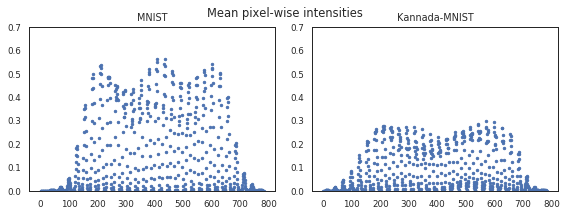

In [53]:
plt.figure(figsize=(8,3))
##########################
plt.subplot(1,2,1)
plt.plot(np.mean(X_mnist_10k_vec,axis=0)/255,'.')
plt.ylim([0,0.7])
plt.title('MNIST')
##########################
plt.subplot(1,2,2)
plt.plot(np.mean(X_KaMnist_test_vec,axis=0)/255,'.')
plt.ylim([0,0.7])
plt.title('Kannada-MNIST')
##########################
plt.suptitle('Mean pixel-wise intensities')
plt.tight_layout()
plt.savefig('../figures/pix-int_both.pdf')
plt.savefig('../figures/pix-int_both.png',dpi=100)

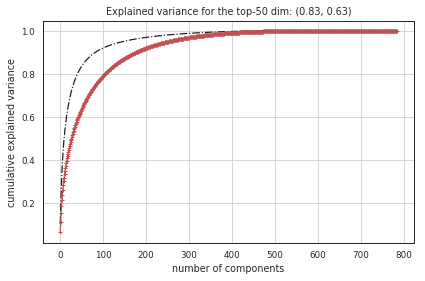

In [71]:
from sklearn.decomposition import PCA
plt.figure(figsize=(6,4))
##########################
pca = PCA().fit(X_mnist_10k_vec)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'-.k')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
##########################
pca = PCA().fit(X_KaMnist_test_vec)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'-+r')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid('on')
##########################
pca1 = PCA(n_components=50).fit(X_mnist_10k_vec)         
pca2 = PCA(n_components=50).fit(X_KaMnist_test_vec)
exp_50=str((np.round(np.cumsum(pca1.explained_variance_ratio_)[-1],2),np.round(np.cumsum(pca2.explained_variance_ratio_)[-1],2)))

plt.title('Explained variance for the top-50 dim: '+exp_50)
plt.tight_layout()
plt.savefig('../figures/pca_expvar_both.pdf')
plt.savefig('../figures/pca_expvar_both.png',dpi=100)

In [0]:
# from time import time
# # Source: https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import offsetbox
# from sklearn import (manifold, datasets, decomposition, ensemble,
#                      discriminant_analysis, random_projection, neighbors)

# X = X_KaMnist_test_vec
# y = y_KaMnist_test
# n_samples, n_features = X.shape
# print(n_samples,n_features)
# n_neighbors = 30


# # ----------------------------------------------------------------------
# # Scale and visualize the embedding vectors
# def plot_embedding(X, title=None):
#     x_min, x_max = np.min(X, 0), np.max(X, 0)
#     X = (X - x_min) / (x_max - x_min)

#     plt.figure()
#     ax = plt.subplot(111)
#     for i in range(X.shape[0]):
#         plt.text(X[i, 0], X[i, 1], str(y[i]),
#                  color=plt.cm.Set1(y[i] / 10.),
#                  fontdict={'weight': 'bold', 'size': 9})

#     if hasattr(offsetbox, 'AnnotationBbox'):
#         # only print thumbnails with matplotlib > 1.0
#         shown_images = np.array([[1., 1.]])  # just something big
#         for i in range(X.shape[0]):
#             dist = np.sum((X[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
#                 # don't show points that are too close
#                 continue
#             shown_images = np.r_[shown_images, [X[i]]]
#             imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(X_KaMnist_test_vec[i].reshape(28,28), cmap=plt.cm.gray_r),
#                 X[i])
#             ax.add_artist(imagebox)
#     plt.xticks([]), plt.yticks([])
#     plt.axis('off')
#     if title is not None:
#         plt.title(title)


# # ----------------------------------------------------------------------
# # Plot images of the digits
# n_img_per_row = 20
# img = np.zeros((30 * n_img_per_row, 30 * n_img_per_row))
# for i in range(n_img_per_row):
#     ix = 30 * i + 1
#     for j in range(n_img_per_row):
#         iy = 30 * j + 1
#         img[ix:ix + 28, iy:iy + 28] = X[i * n_img_per_row + j].reshape((28, 28))

# plt.imshow(img, cmap=plt.cm.binary)
# plt.xticks([])
# plt.yticks([])
# plt.title('A selection from the Kannada-MNIST dataset')


# # ----------------------------------------------------------------------
# # Random 2D projection using a random unitary matrix
# print("Computing random projection")
# rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
# X_projected = rp.fit_transform(X)
# plot_embedding(X_projected, "Random Projection of the digits")


# #----------------------------------------------------------------------
# # Projection on to the first 2 principal components

# print("Computing PCA projection")
# t0 = time()
# X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
# plot_embedding(X_pca,
#                "Principal Components projection of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # Projection on to the first 2 linear discriminant components

# print("Computing Linear Discriminant Analysis projection")
# X2 = X.copy()
# X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
# t0 = time()
# X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
# plot_embedding(X_lda,
#                "Linear Discriminant projection of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # Isomap projection of the digits dataset
# print("Computing Isomap projection")
# t0 = time()
# X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
# print("Done.")
# plot_embedding(X_iso,
#                "Isomap projection of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # Locally linear embedding of the digits dataset
# print("Computing LLE embedding")
# clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                       method='standard')
# t0 = time()
# X_lle = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
# plot_embedding(X_lle,
#                "Locally Linear Embedding of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # Modified Locally linear embedding of the digits dataset
# print("Computing modified LLE embedding")
# clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                       method='modified')
# t0 = time()
# X_mlle = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
# plot_embedding(X_mlle,
#                "Modified Locally Linear Embedding of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # HLLE embedding of the digits dataset
# print("Computing Hessian LLE embedding")
# clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                       method='hessian')
# t0 = time()
# X_hlle = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
# plot_embedding(X_hlle,
#                "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # LTSA embedding of the digits dataset
# print("Computing LTSA embedding")
# clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                       method='ltsa')
# t0 = time()
# X_ltsa = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
# plot_embedding(X_ltsa,
#                "Local Tangent Space Alignment of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # MDS  embedding of the digits dataset
# print("Computing MDS embedding")
# clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
# t0 = time()
# X_mds = clf.fit_transform(X)
# print("Done. Stress: %f" % clf.stress_)
# plot_embedding(X_mds,
#                "MDS embedding of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # Random Trees embedding of the digits dataset
# print("Computing Totally Random Trees embedding")
# hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
#                                        max_depth=5)
# t0 = time()
# X_transformed = hasher.fit_transform(X)
# pca = decomposition.TruncatedSVD(n_components=2)
# X_reduced = pca.fit_transform(X_transformed)

# plot_embedding(X_reduced,
#                "Random forest embedding of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # Spectral embedding of the digits dataset
# print("Computing Spectral embedding")
# embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
#                                       eigen_solver="arpack")
# t0 = time()
# X_se = embedder.fit_transform(X)

# plot_embedding(X_se,
#                "Spectral embedding of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # t-SNE embedding of the digits dataset
# print("Computing t-SNE embedding")
# tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
# t0 = time()
# X_tsne = tsne.fit_transform(X)

# plot_embedding(X_tsne,
#                "t-SNE embedding of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # NCA projection of the digits dataset
# print("Computing NCA projection")
# nca = neighbors.NeighborhoodComponentsAnalysis(n_components=2, random_state=0)
# t0 = time()
# X_nca = nca.fit_transform(X, y)

# plot_embedding(X_nca,
#                "NCA embedding of the digits (time %.2fs)" %
#                (time() - t0))
# plt.show()